# ARIMA on Store Sales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Filter time-series sales data
df = pd.read_csv('../data/train_2016.csv', index_col='date')
df_train = df.groupby('date')['sales'].mean().to_frame().sort_index()
df_train.head()

,sales
date,
2016-01-04,325.457973
2016-01-05,298.089266
2016-01-06,277.510852
2016-01-07,282.594962
2016-01-08,287.818983


### Test Stationarity by ADF test


In [3]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    adf_result = adfuller(df)
    print('ADF Statistic: ', adf_result[0])
    print('p-value: ', adf_result[1])
    print('Critical Values: ')
    for key, value in adf_result[4].items():
        print(f'{key}: {value}')
        
adf_test(df_train['sales'])

ADF Statistic:  -2.2489263928214314
p-value:  0.18896932843114256
Critical Values: 
1%: -3.449336554273722
5%: -2.8699055166063085
10%: -2.571226758215748


p-value > 0.05, the time-series data is not stationary. Apply differencing to make data stationary

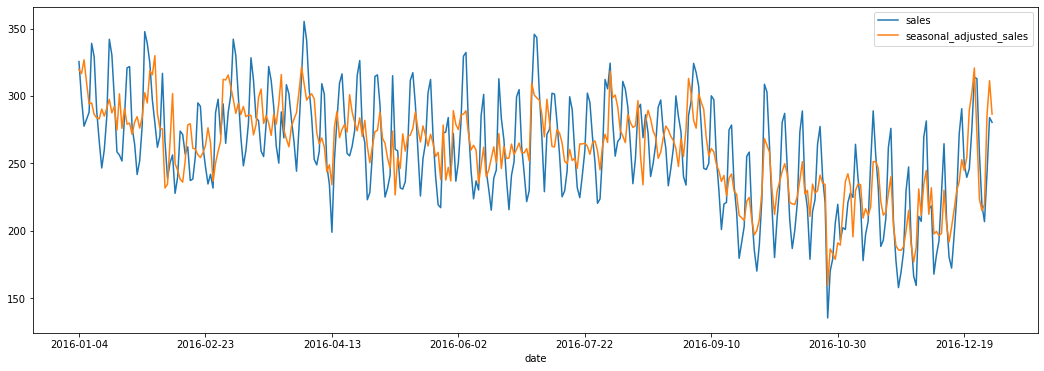

ADF Statistic:  -3.1573358519749406
p-value:  0.022590920765841165
Critical Values: 
1%: -3.448853029339765
5%: -2.869693115704379
10%: -2.571113512498422


In [5]:
# remove seasonal component
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_train['sales'], period=7, model='multiplicative')
df_train['seasonal_adjusted_sales'] = df_train['sales'] / decomposition.seasonal

plt.rcParams['figure.figsize'] = [18, 6]
df_train.plot()
plt.show()

adf_test(df_train['seasonal_adjusted_sales'])

In [7]:
# remove trend component - differencing d = 1
d = 1
df_train['sales_diff'] = df_train['seasonal_adjusted_sales'].diff(d)
df_train_seasonally_adjusted = df_train.dropna()

adf_test(df_train_seasonally_adjusted['sales_diff'])

ADF Statistic:  -8.231459303163211
p-value:  6.047155548801253e-13
Critical Values: 
1%: -3.4492815848836296
5%: -2.8698813715275406
10%: -2.5712138845950587


* Using period as 7 to remove seasonality
* Using 1st order differencing to remove trend   
  
The final p-value of ADF test is 0.01, the time-series data is stationary

### ACF and PACF

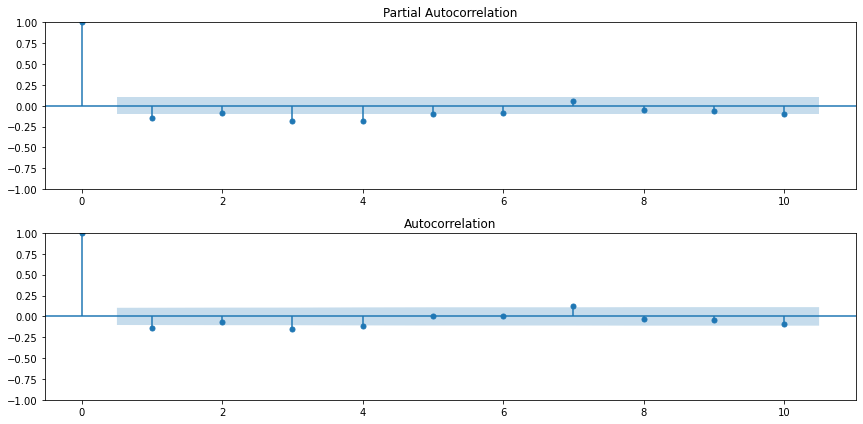

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# AR - PACF
plot_pacf(df_train_seasonally_adjusted['sales_diff'], lags=10, ax=ax[0])

# MA - ACF
plot_acf(df_train_seasonally_adjusted['sales_diff'], lags=10, ax=ax[1])

plt.tight_layout()
plt.show()

p and q are both 0. for more consideration, we can try p = 1, q = 1

### ARIMA Model

In [9]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_train['seasonal_adjusted_sales'], order=(0, 1, 0))
results = model.fit()

print(results.summary())

                                  SARIMAX Results                                  
Dep. Variable:     seasonal_adjusted_sales   No. Observations:                  362
Model:                      ARIMA(0, 1, 0)   Log Likelihood               -1550.249
Date:                     Sun, 10 Nov 2024   AIC                           3102.498
Time:                             15:27:05   BIC                           3106.387
Sample:                                  0   HQIC                          3104.044
                                     - 362                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       314.4342     16.808     18.707      0.000     281.491     347.378
Ljung-Box (L1) (Q):                   7.52   Jarque-Bera (JB):                53.43
Prob(Q)

/Users/xiao/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiao/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiao/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [10]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_train['seasonal_adjusted_sales'], order=(1, 1, 1))
results = model.fit()

print(results.summary())

                                  SARIMAX Results                                  
Dep. Variable:     seasonal_adjusted_sales   No. Observations:                  362
Model:                      ARIMA(1, 1, 1)   Log Likelihood               -1529.302
Date:                     Sun, 10 Nov 2024   AIC                           3064.605
Time:                             15:27:07   BIC                           3076.272
Sample:                                  0   HQIC                          3069.243
                                     - 362                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6624      0.055     12.080      0.000       0.555       0.770
ma.L1         -0.9294      0.029    -32.273      0.000      -0.986      -0.873
sigma2      

/Users/xiao/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiao/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xiao/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


p, q = 1, 1 or p, q = 0, 0 has no significant impact on the model.

#### Residuals analysis

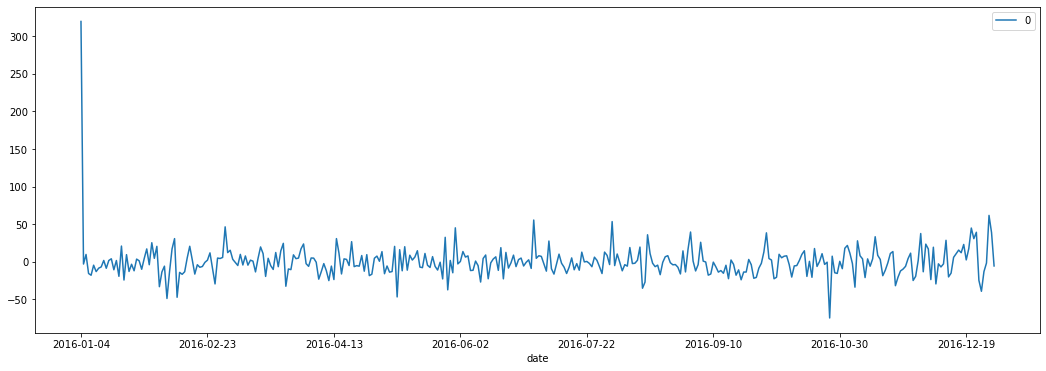

TypeError: not all arguments converted during string formatting

In [18]:
residuals = pd.DataFrame(results.resid)

residuals.plot()
plt.show()

residuals.describe()

# Normality test
from scipy import stats

stat, p = stats.shapiro(residuals)

print('Normality test: p=%.3f' % (stat, p))




The mean of residuals is 0.8 but the std is 24.75, which indicates that the model is not very good. the fluctuation of the residuals is too large. But as the benchmark, we will finish this model prediction first.